# CycleGAN

## 设定输入管线

In [1]:
import tensorflow as tf
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

In [2]:
def load(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.io.decode_png(image)

  # Convert image to float32 tensors
  image = tf.cast(image, tf.float32)
  return image

In [3]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
# IMG_WIDTH = 256
# IMG_HEIGHT = 256

IMG_WIDTH = 512
IMG_HEIGHT = 512

In [4]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [5]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [6]:
def random_jitter(image):
  # # resizing to 286 x 286 x 3
  # image = tf.image.resize(image, [286, 286],
  #                         method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # resizing to 542 x 542 x 3
  image = tf.image.resize(image, [542, 542],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [7]:
def load_image_train(image_file):
  image = load(image_file)
  image = random_jitter(image)
  image = normalize(image)

  return image

In [8]:
def load_image_test(image_file):
  image = load(image_file)
  image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  image = normalize(image)

  return image

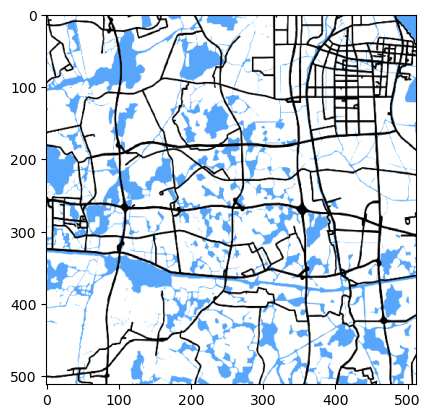

In [11]:
img=load_image_train('dataset/trainA/屏幕截图 2023-04-08 223528.png')
plt.imshow(img*0.5+0.5)

In [12]:
train_A = tf.data.Dataset.list_files('dataset/trainA/*.png')
train_B = tf.data.Dataset.list_files('dataset/trainB/*.png')
test_A = tf.data.Dataset.list_files('dataset/testA/*.png')
test_B = tf.data.Dataset.list_files('dataset/testB/*.png')

In [13]:
train_A = train_A.cache().map(
    load_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_B = train_B.cache().map(
    load_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_A = test_A.map(
    load_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_B = test_B.map(
    load_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [16]:
city_texture = next(iter(train_A))
plain = next(iter(train_B))

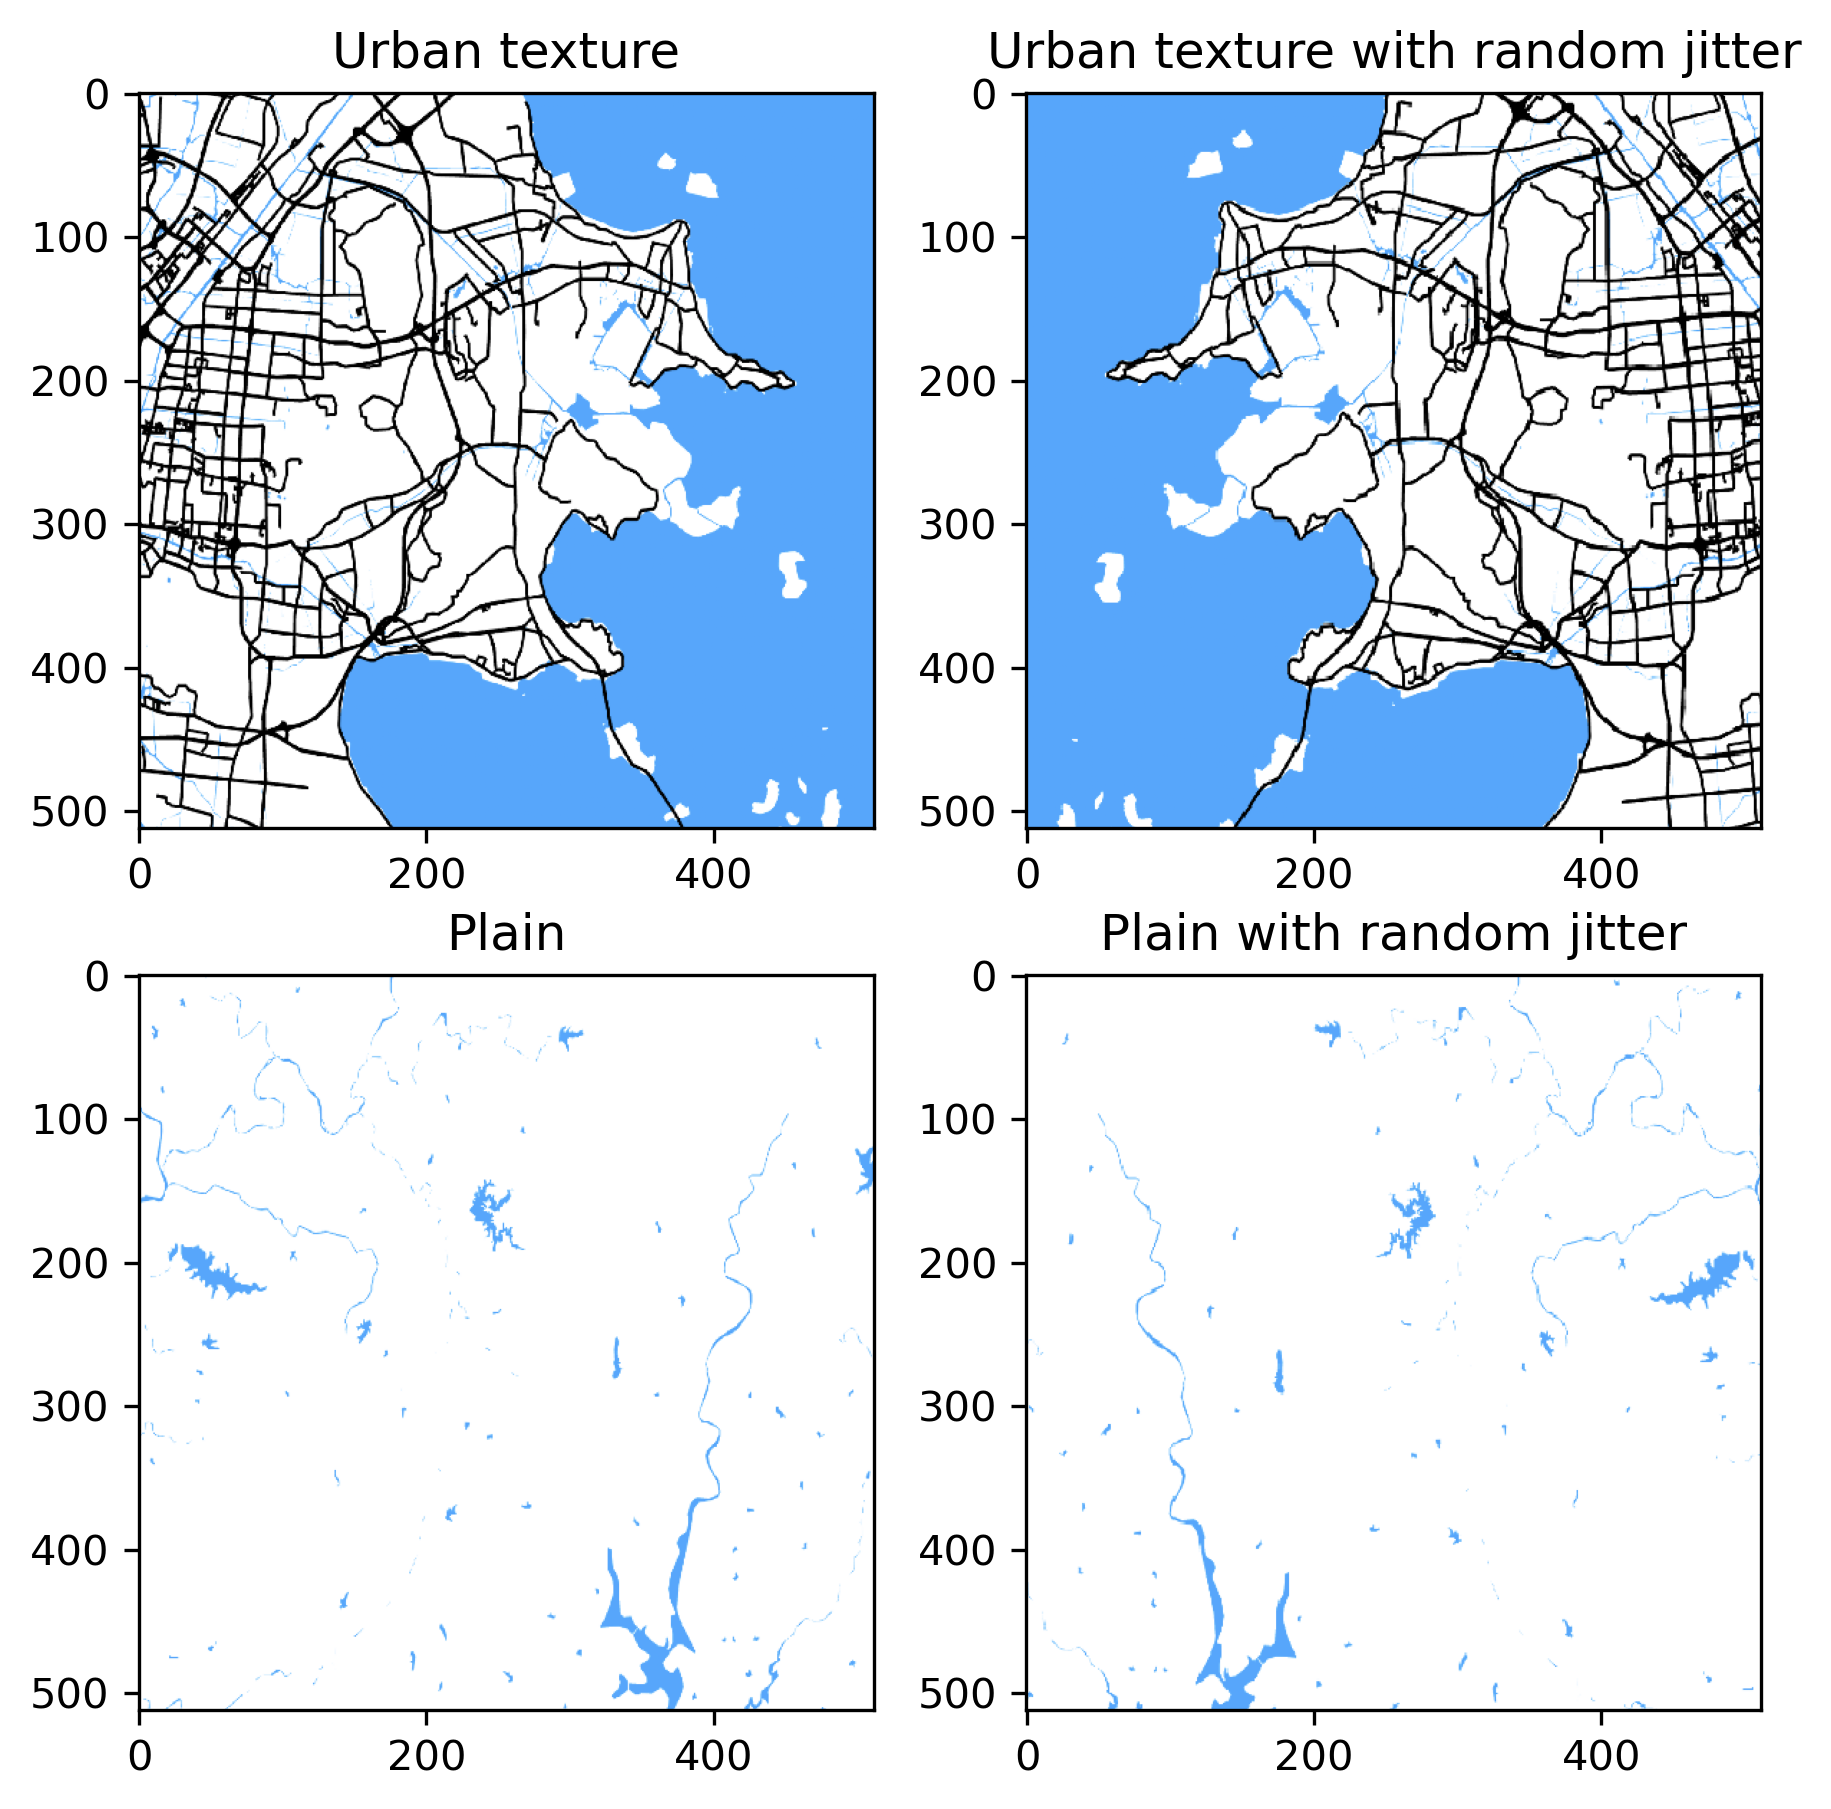

In [20]:
plt.figure(dpi=300,figsize=(7,7))

plt.subplot(2,2,1)
plt.title('Urban texture')
plt.imshow(city_texture[0] * 0.5 + 0.5)

plt.subplot(2,2,2)
plt.title('Urban texture with random jitter')
plt.imshow(random_jitter(city_texture[0]) * 0.5 + 0.5)

plt.subplot(2,2,3)
plt.title('Plain')
plt.imshow(plain[0] * 0.5 + 0.5)

plt.subplot(2,2,4)
plt.title('Plain with random jitter')
plt.imshow(random_jitter(plain[0]) * 0.5 + 0.5)

## 导入并重用 Pix2Pix 模型

In [21]:
import pix2pix
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


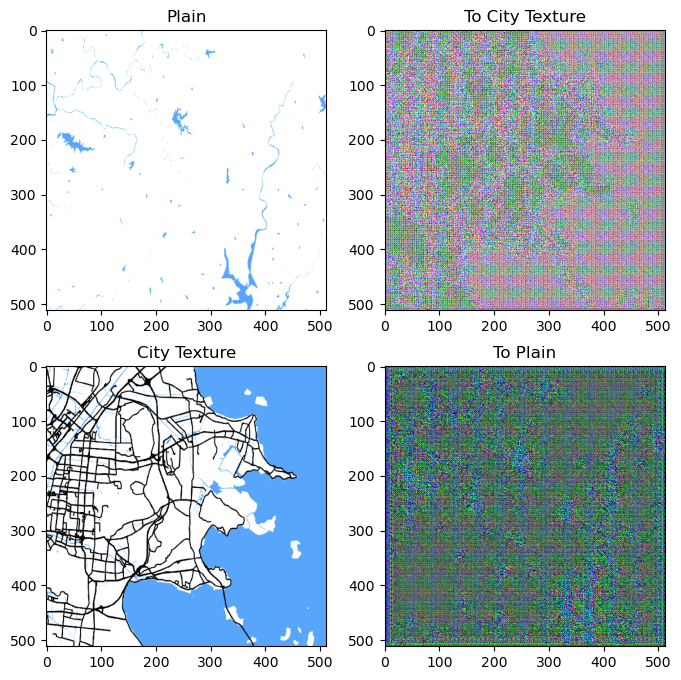

In [23]:
to_plain = generator_g(plain)
to_city_texture = generator_f(city_texture)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [plain, to_city_texture, city_texture, to_plain]
title = ['Plain', 'To City Texture', 'City Texture', 'To Plain']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

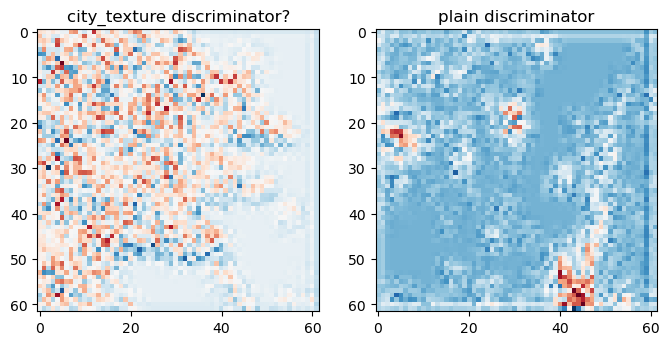

In [25]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('city_texture discriminator?')
plt.imshow(discriminator_y(city_texture)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('plain discriminator')
plt.imshow(discriminator_x(plain)[0, ..., -1], cmap='RdBu_r')

plt.show()

## 损失函数

在 CycleGAN 中，没有可训练的成对数据，因此无法保证输入 `x` 和 目标 `y` 数据对在训练期间是有意义的。所以为了强制网络学习正确的映射，作者提出了循环一致损失。

判别器损失和生成器损失和 [pix2pix](https://google.tensorflow.cn/tutorials/generative/pix2pix#define_the_loss_functions_and_the_optimizer) 中所使用的类似。

In [ ]:
LAMBDA = 10

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

循环一致意味着结果应接近原始输出。例如，将一句英文译为法文，随后再从法文翻译回英文，最终的结果句应与原始句输入相同。

在循环一致损失中，

- 图片 $X$ 通过生成器 $G$ 传递，该生成器生成图片 $\hat{Y}$。
- 生成的图片 $\hat{Y}$ 通过生成器 $F$ 传递，循环生成图片 $\hat{X}$。
- 在 $X$ 和 $\hat{X}$ 之间计算平均绝对误差。

$$forward\ cycle\ consistency\ loss: X -&gt; G(X) -&gt; F(G(X)) \sim \hat{X}$$

$$backward\ cycle\ consistency\ loss: Y -&gt; F(Y) -&gt; G(F(Y)) \sim \hat{Y}$$



In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

如上所示，生成器 $G$ 负责将图片 $X$ 转换为 $Y$。一致性损失表明，如果您将图片 $Y$ 馈送给生成器 $G$，它应当生成真实图片 $Y$ 或接近于 $Y$ 的图片。

$$Identity\ loss = |G(Y) - Y| + |F(X) - X|$$

$$Identity\ loss = |G(Y) - Y| + |F(X) - X|$$

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

为所有生成器和判别器初始化优化器。

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

## 训练


In [ ]:
EPOCHS = 100

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

尽管训练循环看起来很复杂，其实包含四个基本步骤：

- 获取预测。
- 计算损失值。
- 使用反向传播计算损失值。
- 将梯度应用于优化器。

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_B, train_A)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, plain)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

## 使用测试数据集进行生成

In [ ]:
# Run the trained model on the test dataset
for inp in test_B.take(5):
  generate_images(generator_g, inp)

In [26]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [27]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

Launching TensorBoard...